In [1]:
import os
import re
import math
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches

from soundbay.utils.metadata_processing import (
    bg_from_non_overlap_calls,
    correct_call_times_with_duration,
    non_overlap_df,
)

## Load data

In [2]:
current_directory = os.getcwd()

deepvoice_directory = os.path.dirname(
    os.path.dirname(os.path.dirname(current_directory))
)

nefsc_folder_path = os.path.join(
    deepvoice_directory, "datasets", "nefsc_sbnms_200903_nopp6_ch10"
)

In [3]:
data_path = f"{nefsc_folder_path}/detections/NEFSC_SBNMS_200903_NOPP6_CH10_allbaleen_detection_log.csv"
original_metadata = pd.read_csv(data_path)
audio_files_path = f"{nefsc_folder_path}/source-audio/"

## Utils

In [4]:
FILES_DELTA = 15 * 60  # 15 minutes files


def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)


def filetime_from_time(time_str):
    sec_time = get_sec(time_str)
    filetime_sec = math.floor(sec_time / FILES_DELTA) * FILES_DELTA
    filetime_str = time.strftime("%H%M%S", time.gmtime(filetime_sec))
    return filetime_str


def get_time_and_date(iso_input):
    date, time_str = iso_input.split("T")
    time_str = time_str.split("-")[0]
    return date, time_str


def iso_to_file_name(iso_input):
    date, time_str = get_time_and_date(iso_input)
    filename_time = filetime_from_time(time_str)
    filename_date = date.replace("-", "")
    return f"NOPP6_EST_{filename_date}_{filename_time}_CH10"


def get_time_in_file(iso_input, type="start"):
    date, time_str = get_time_and_date(iso_input)
    time_int = get_sec(time_str)
    time_in_file = time_int - (time_int // FILES_DELTA) * FILES_DELTA
    if type == "end" and time_in_file == 0:
        time_in_file = FILES_DELTA
    return time_in_file


def get_previous_filename(filename):
    file_parts = filename.split("_")
    time_part = file_parts[-2]
    h, m, s = re.findall("..", time_part)
    time_sec = int(h) * 3600 + int(m) * 60 + int(s)
    new_time = time_sec - FILES_DELTA
    assert new_time % FILES_DELTA == 0, "whyyyy"
    new_time_part = time.strftime("%H%M%S", time.gmtime(new_time))
    file_parts[-2] = new_time_part
    return "_".join(file_parts)

In [5]:
def calculate_overlaps_with_buffer(df, buffer_seconds):
    # Convert start and end times to datetime format
    df["Start_DateTime_ISO8601"] = pd.to_datetime(df["Start_DateTime_ISO8601"])
    df["End_DateTime_ISO8601"] = pd.to_datetime(df["End_DateTime_ISO8601"])

    # Sort the data by start time for easier analysis
    df = df.sort_values(by=["Start_DateTime_ISO8601", "filename"]).reset_index(
        drop=True
    )

    # Efficient overlap detection handling multi-sample overlaps
    overlaps = []
    active_intervals = []

    for i in range(len(df)):
        current_species = df.loc[i, "Species"]
        current_start = df.loc[i, "Start_DateTime_ISO8601"] - timedelta(
            seconds=buffer_seconds
        )  # Extend start time by buffer
        current_end = df.loc[i, "End_DateTime_ISO8601"] + timedelta(
            seconds=buffer_seconds
        )  # Extend end time by buffer
        current_filename = df.loc[i, "filename"]
        current_unique_id = df.loc[i, "unique_id"]

        # Remove intervals that have ended
        active_intervals = [
            interval
            for interval in active_intervals
            if interval["end"] > current_start
        ]

        # Check for overlaps with all active intervals
        for interval in active_intervals:
            if interval["species"] != current_species:
                overlap_start = max(interval["start"], current_start)
                overlap_end = min(interval["end"], current_end)

                # Ensure there is an actual overlap
                if overlap_start < overlap_end:
                    overlaps.append(
                        {
                            "Current Species": interval["species"],
                            "Next Species": current_species,
                            "Overlap Start": overlap_start,
                            "Overlap End": overlap_end,
                            "Overlaps Duration": (
                                overlap_end - overlap_start
                            ).total_seconds(),
                            "File 1": interval["filename"],
                            "File 1 Unique ID": interval["unique_id"],
                            "File 2": current_filename,
                            "File 2 Unique ID": current_unique_id,
                        }
                    )

        # Add the current interval to the active list
        active_intervals.append(
            {
                "species": current_species,
                "start": current_start,
                "end": current_end,
                "filename": current_filename,
                "unique_id": current_unique_id,
            }
        )

    # Convert overlaps to a DataFrame for better visualization
    overlaps_df = pd.DataFrame(overlaps)

    # Remove duplicates based on overlap times and species, ignoring different filenames
    overlaps_df = overlaps_df.drop_duplicates(
        subset=[
            "Current Species",
            "Next Species",
            "Overlap Start",
            "Overlap End",
        ]
    )

    # Remove timezone information from the datetime columns in the overlaps_df
    overlaps_df["Overlap Start"] = overlaps_df["Overlap Start"].dt.tz_convert(
        None
    )
    overlaps_df["Overlap End"] = overlaps_df["Overlap End"].dt.tz_convert(None)

    return overlaps_df.reset_index(drop=True)

## Process

In [6]:
original_metadata["filename"] = [
    iso_to_file_name(x) for x in original_metadata["End_DateTime_ISO8601"]
]
original_metadata["begin_time"] = [
    get_time_in_file(x) for x in original_metadata["Start_DateTime_ISO8601"]
]
original_metadata["end_time"] = [
    get_time_in_file(x, "end")
    for x in original_metadata["End_DateTime_ISO8601"]
]
original_metadata["call_length"] = (
    original_metadata["end_time"] - original_metadata["begin_time"]
)

In [7]:
# split annotations that originate from different files to the corresponding files
problematic_samples_filter = original_metadata["call_length"] < 0
after_split_samples = original_metadata[problematic_samples_filter].copy()
original_metadata.loc[problematic_samples_filter, "end_time"] = FILES_DELTA
original_metadata.loc[problematic_samples_filter, "filename"] = [
    get_previous_filename(x)
    for x in original_metadata[problematic_samples_filter]["filename"]
]
after_split_samples["begin_time"] = 0
new_metadata = pd.concat(
    [original_metadata, after_split_samples], ignore_index=True
)

In [8]:
# remove calls with length of zero
new_metadata = new_metadata[new_metadata["call_length"] != 0]

In [9]:
# correct files duration
new_metadata = correct_call_times_with_duration(
    new_metadata, audio_files_path=audio_files_path
)

In [10]:
# split to high_prob and all data
high_prob_metadata = new_metadata[
    new_metadata["Detection_Confidence"] == "Detected"
]
high_prob_metadata = high_prob_metadata.drop(columns=["Detection_Confidence"])
all_metadata = new_metadata.drop(columns=["Detection_Confidence"])

In [11]:
# merge overlapping calls
all_metadata = non_overlap_df(all_metadata)
high_prob_metadata = non_overlap_df(high_prob_metadata)

In [12]:
all_metadata["unique_id"] = (
    all_metadata.index.astype(str)
    + all_metadata["Selection"].astype(str)
    + all_metadata["filename"]
)

In [13]:
overlaps_df = calculate_overlaps_with_buffer(all_metadata, buffer_seconds=0)
print(f"No buffer: {overlaps_df.shape[0]} overlaps found")
# Example usage with different buffer durations
buffer_1s = calculate_overlaps_with_buffer(all_metadata, buffer_seconds=1)
print(f"1s buffer: {buffer_1s.shape[0]} overlaps found")
buffer_2s = calculate_overlaps_with_buffer(all_metadata, buffer_seconds=2)
print(f"2s buffer: {buffer_2s.shape[0]} overlaps found")

No buffer: 14 overlaps found
1s buffer: 3115 overlaps found
2s buffer: 8683 overlaps found


/var/folders/6n/0lq5ggb52m7csvhcgmxs7vjc0000gn/T/ipykernel_56030/1708689143.py:47: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.Rectangle(
/var/folders/6n/0lq5ggb52m7csvhcgmxs7vjc0000gn/T/ipykernel_56030/1708689143.py:58: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.Rectangle(


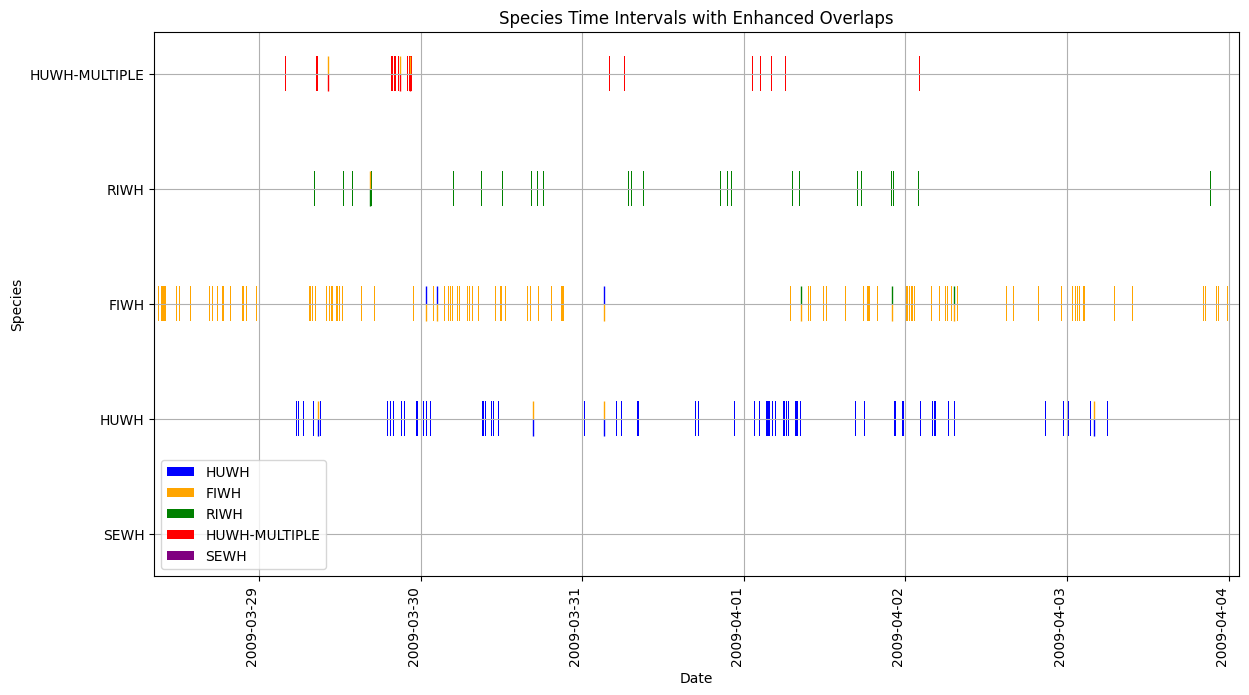

In [14]:
# Define species colors
species_colors = {
    "SEWH": "purple",
    "HUWH": "blue",
    "FIWH": "orange",
    "RIWH": "green",
    "HUWH-MULTIPLE": "red",
}

# species_list = df['Species'].unique()
species_list = ["HUWH", "FIWH", "RIWH", "HUWH-MULTIPLE", "SEWH"]

# Update the species_to_numeric mapping to include all species, including HUWH-MULTIPLE
species_to_numeric = {
    species: idx for idx, species in enumerate(species_colors.keys())
}

plt.figure(figsize=(14, 8))

# Plot intervals
for species in species_list:
    species_data = all_metadata[all_metadata["Species"] == species]
    plt.barh(
        y=species_to_numeric[species],
        width=species_data["End_DateTime_ISO8601"]
        - species_data["Start_DateTime_ISO8601"],
        left=species_data["Start_DateTime_ISO8601"],
        height=0.3,
        color=species_colors.get(species, "gray"),
        label=species,
    )

# Plot overlaps with split colors
for _, overlap in overlaps_df.iterrows():
    species_1 = overlap["Current Species"]
    species_2 = overlap["Next Species"]

    overlap_start = overlap["Overlap Start"]
    overlap_end = overlap["Overlap End"]
    overlap_duration = overlap_end - overlap_start

    # Calculate segment height (splitting into two parts)
    segment_height = 0.3 / 2  # Splitting the height

    # Plot first segment with species 1 color
    plt.gca().add_patch(
        patches.Rectangle(
            (overlap_start, species_to_numeric[species_1] - segment_height),
            overlap_duration,
            segment_height,
            color=species_colors[species_1],
            edgecolor="black",
        )
    )

    # Plot second segment with species 2 color
    plt.gca().add_patch(
        patches.Rectangle(
            (overlap_start, species_to_numeric[species_1]),
            overlap_duration,
            segment_height,
            color=species_colors[species_2],
            edgecolor="black",
        )
    )

# Improve x-axis format to show only dates in vertical format
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gcf().autofmt_xdate(rotation=90)

# Update y-ticks to show species names
plt.yticks(list(species_to_numeric.values()), list(species_to_numeric.keys()))

# Title and labels
plt.title("Species Time Intervals with Enhanced Overlaps")
plt.xlabel("Date")
plt.ylabel("Species")

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.show()

In [15]:
with_bg_metadata_all = bg_from_non_overlap_calls(all_metadata)
with_bg_metadata_all = with_bg_metadata_all.sort_values(
    by=["filename", "begin_time"]
)

with_bg_metadata_high = bg_from_non_overlap_calls(high_prob_metadata)
with_bg_metadata_high = with_bg_metadata_high.sort_values(
    by=["filename", "begin_time"]
)

In [16]:
# Create a mapping from species to unique labels
species_to_label_all = {
    species: idx + 1
    for idx, species in enumerate(with_bg_metadata_all["Species"].unique())
}
species_to_label_high = {
    species: idx + 1
    for idx, species in enumerate(with_bg_metadata_high["Species"].unique())
}

# Assign these labels to the 'label' column where it is non-zero
with_bg_metadata_all.loc[with_bg_metadata_all["label"] != 0, "label"] = (
    with_bg_metadata_all["Species"].map(species_to_label_all)
)
with_bg_metadata_high.loc[with_bg_metadata_high["label"] != 0, "label"] = (
    with_bg_metadata_high["Species"].map(species_to_label_high)
)

In [24]:
species_to_label_all

{'HUWH': 1, 'FIWH': 2, 'RIWH': 3, 'HUWH-MULTIPLE': 4, 'SEWH': 5}

In [17]:
with_bg_metadata_all["label"] = np.array(with_bg_metadata_all["label"]).astype(
    "int"
)
with_bg_metadata_high["label"] = np.array(
    with_bg_metadata_high["label"]
).astype("int")

In [18]:
# split to train and val
val_filter = with_bg_metadata_all["filename"].str.contains("20090330")
train_metadata = with_bg_metadata_all[~val_filter]
val_metadata = with_bg_metadata_all[val_filter]
print(f"{len(train_metadata)=}, {len(val_metadata)=}")

len(train_metadata)=89707, len(val_metadata)=22964


In [19]:
# same for high prob
val_filter = with_bg_metadata_high["filename"].str.contains("20090330")
high_prob_train_metadata = with_bg_metadata_high[~val_filter]
high_prob_val_metadata = with_bg_metadata_high[val_filter]
print(f"{len(high_prob_train_metadata)=}, {len(high_prob_val_metadata)=}")

len(high_prob_train_metadata)=77143, len(high_prob_val_metadata)=21102


In [20]:
# take the bg to the high prob as well from the full dataset
high_prob_train_metadata_calls = high_prob_train_metadata[
    high_prob_train_metadata["label"] != 0
]
all_bg_train = train_metadata[train_metadata["label"] == 0]
high_prob_train_metadata = pd.concat(
    [high_prob_train_metadata_calls, all_bg_train]
)
high_prob_train_metadata = high_prob_train_metadata.sort_values(
    by=["filename", "begin_time"]
)

high_prob_val_metadata_calls = high_prob_val_metadata[
    high_prob_val_metadata["label"] != 0
]
all_bg_val = val_metadata[val_metadata["label"] == 0]
high_prob_val_metadata = pd.concat([high_prob_val_metadata_calls, all_bg_val])
high_prob_val_metadata = high_prob_val_metadata.sort_values(
    by=["filename", "begin_time"]
)

In [21]:
def get_time_in_hrs_format(time_secs):
    return (
        time_secs // 3600,
        (time_secs - time_secs // 3600 * 3600) // 60,
        time_secs % 60,
    )


for name, meta in {
    "train": train_metadata,
    "val": val_metadata,
    "train_high_prob": high_prob_train_metadata,
    "val_high_prob": high_prob_val_metadata,
    "with_bg_metadata_high": with_bg_metadata_high,
    "with_bg_metadata_all": with_bg_metadata_all,
}.items():
    print(name)
    print(f"Number of samples: {len(meta)}")
    print(f"Labels breakdown: {meta['label'].value_counts()}")
    h, m, s = get_time_in_hrs_format(
        meta["call_length"][meta["label"] == 1].sum()
    )
    print(f"Calls length: {h}:{m}:{s}")
    h, m, s = get_time_in_hrs_format(
        meta["call_length"][meta["label"] == 0].sum()
    )
    print(f"Background length: {h}:{m}:{s}")
    # print(f"Calls length: {time.strftime('%H:%M:%S', time.gmtime(meta['call_length'][meta['label']==1].sum()))}")
    # print(f"Background length: {time.strftime('%H:%M:%S', time.gmtime(meta['call_length'][meta['label']==0].sum()))}")
    print(
        "-----------------------------------------------------------------------------"
    )

train
Number of samples: 89707
Labels breakdown: label
0    44569
2    28689
1    10400
3     5073
4      973
5        3
Name: count, dtype: int64
Calls length: 8:48:6
Background length: 99:16:10
-----------------------------------------------------------------------------
val
Number of samples: 22964
Labels breakdown: label
0    11434
2     7774
1     2706
3      888
4      162
Name: count, dtype: int64
Calls length: 2:9:32
Background length: 15:47:44
-----------------------------------------------------------------------------
train_high_prob
Number of samples: 83415
Labels breakdown: label
0    44569
3    25792
1     8474
2     3588
4      992
Name: count, dtype: int64
Calls length: 7:7:17
Background length: 99:16:10
-----------------------------------------------------------------------------
val_high_prob
Number of samples: 22033
Labels breakdown: label
0    11434
3     7306
1     2497
2      630
4      166
Name: count, dtype: int64
Calls length: 1:59:32
Background length: 15:47:4

In [22]:
train_metadata.to_csv("train_all_labels.csv", index=False)
val_metadata.to_csv("val_all_labels.csv", index=False)
high_prob_train_metadata.to_csv("train_all_labels_high_prob.csv", index=False)
high_prob_val_metadata.to_csv("val_all_labels_high_prob.csv", index=False)